In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style = 'darkgrid')

In [3]:
con = psycopg2.connect(dbname='mimic', user='sudarshan', host='/var/run/postgresql')

In [4]:
counts = pd.read_sql_query('select count(distinct text) as notes, count(distinct hadm_id) as adms from data where length(text) between 500 and 6000;', con)
n_notes, n_adms = counts.iloc[0][0], counts.iloc[0][1]

In [5]:
query = """
select count(distinct text) as notes, count(distinct hadm_id) as adms, class_label from data where length(text) between 500 and 6000 group by class_label order by class_label
"""
df = pd.read_sql_query(query, con)
desc = ['not used', 'negative class', 'positive class']
df['class_label'] = desc
df = df.reindex([2,1,0])
df.reset_index(inplace=True, drop=True)
df

,notes,adms,class_label
0,7426,4255,positive class
1,6979,1727,negative class
2,16244,8815,not used


In [6]:
mdf = df.copy()
mdf.rename(columns={'adms':'Number of Admissions', 'notes':'Number of Notes'}, inplace=True)
mdf = pd.melt(mdf, id_vars='class_label', var_name='Legend', value_name='counts')

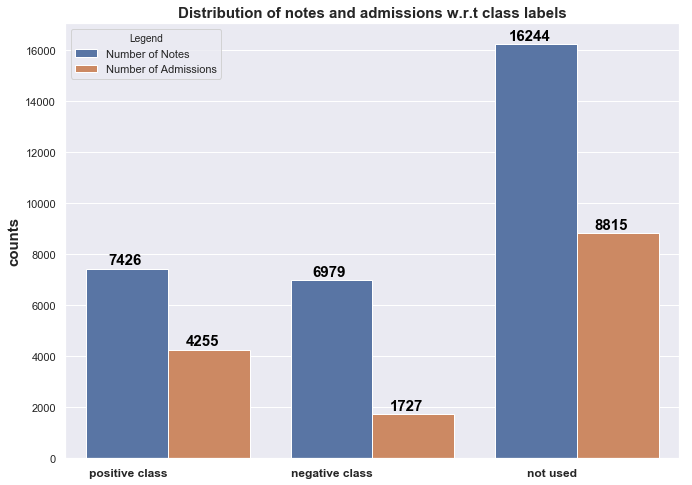

In [7]:
fig, ax = plt.subplots(figsize=(11, 8))

sns.barplot(x='class_label', y='counts', hue='Legend', data=mdf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontweight='bold', fontsize=12)
ax.set_xlabel("")
ax.set_ylabel('counts', fontweight='bold', fontsize=15)
ax.set_title('Distribution of notes and admissions w.r.t class labels', fontweight='bold', fontsize=15)

for index, row in mdf.iterrows():
    if index < len(mdf)//2:
        ax.text(index-0.13, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=15)
    else:
        ax.text(index % (len(mdf)//2)+0.25, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=15)

In [8]:
def plot_intervals(df, mdf):    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))

    sns.barplot(x='days', y='n_notes', data=df, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax[0].set_xlabel("")
    ax[0].set_ylabel('Number of notes', fontweight='bold', fontsize=15)
    ax[0].set_title('Distribution of notes and admissions w.r.t chart time and ICU admit time (in days)', fontweight='bold', fontsize=15)

    ax[0].text(len(df)/2, ax[0].get_ylim()[1]*0.80, f'Total number of notes = {n_notes}', fontweight='bold', fontsize=15, ha='center', va='bottom')

    for index, row in df.iterrows():
        ax[0].text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

    sns.barplot(x='days', y='counts', hue='Legend', data=mdf, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax[1].set_xlabel("Time between note chart time and ICU admit time (days)\n 't' is the time-to-ICU admit time", fontweight='bold', fontsize=15)
    ax[1].set_ylabel('count', fontweight='bold', fontsize=15)

    ax[1].text(len(df)/2, ax[0].get_ylim()[1]*0.80, f'Total number of notes = {n_notes}\nTotal number of hospital admissions = {n_adms}', fontweight='bold', fontsize=15, ha='center', va='bottom')

    for index, row in mdf.iterrows():
        if index < len(mdf)//2:
            ax[1].text(index+0.04, row['counts'] + 100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)
        else:
            ax[1].text(index % (len(mdf)//2) + 0.36, row['counts'] + 100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)

In [9]:
query = """
select count(distinct text) as n_notes, count(distinct hadm_id) as n_adms from data where length(text) between 500 and 6000 group by chartinterval order by chartinterval;
"""

df = pd.read_sql_query(query, con)
intervals = [f'{i} < t < {i+1}' for i in range(15)]
intervals.append('t > 15')
df['days'] = intervals

# df.drop(0, axis=0, inplace=True)
# df.reset_index(inplace=True, drop=True)

mdf = df.copy()
mdf.rename(columns={'n_adms':'Number of Admissions', 'n_notes':'Number of Notes'}, inplace=True)
mdf = pd.melt(mdf, id_vars='days', var_name='Legend', value_name='counts')

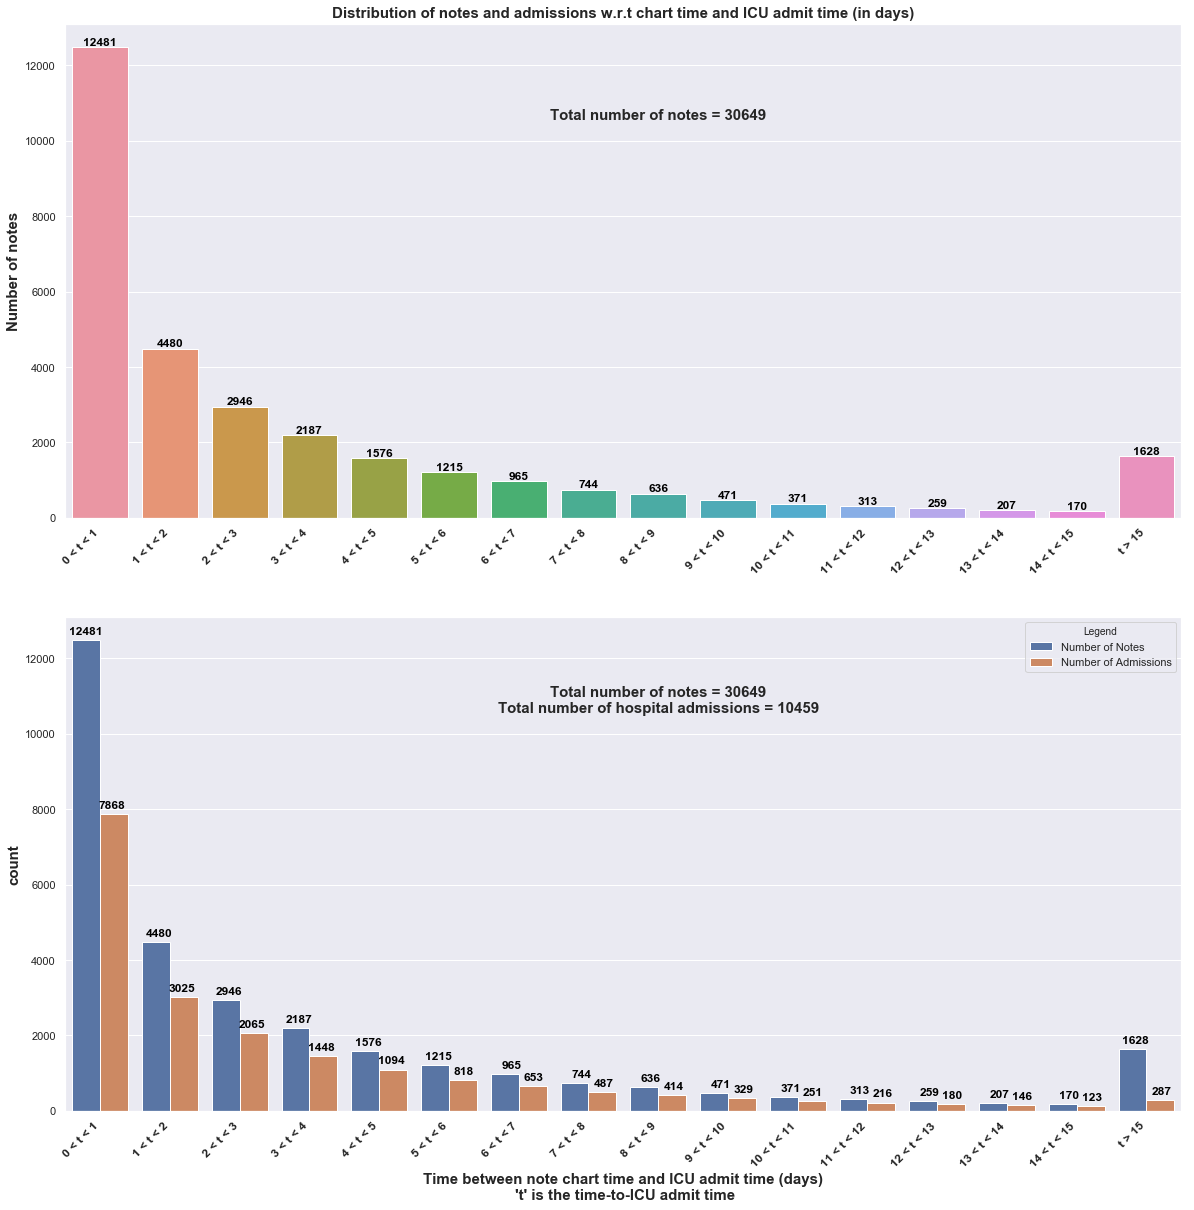

In [10]:
plot_intervals(df, mdf)

In [11]:
query = """
select hadm_id, count(distinct text) as n_notes from data where length(text) between 500 and 6000 group by hadm_id order by hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,hadm_id,n_notes
0,100009,2
1,100012,2
2,100018,2
3,100020,2
4,100021,3


Text(10, 5487.72, 'Total number of hospital admissions = 10459')

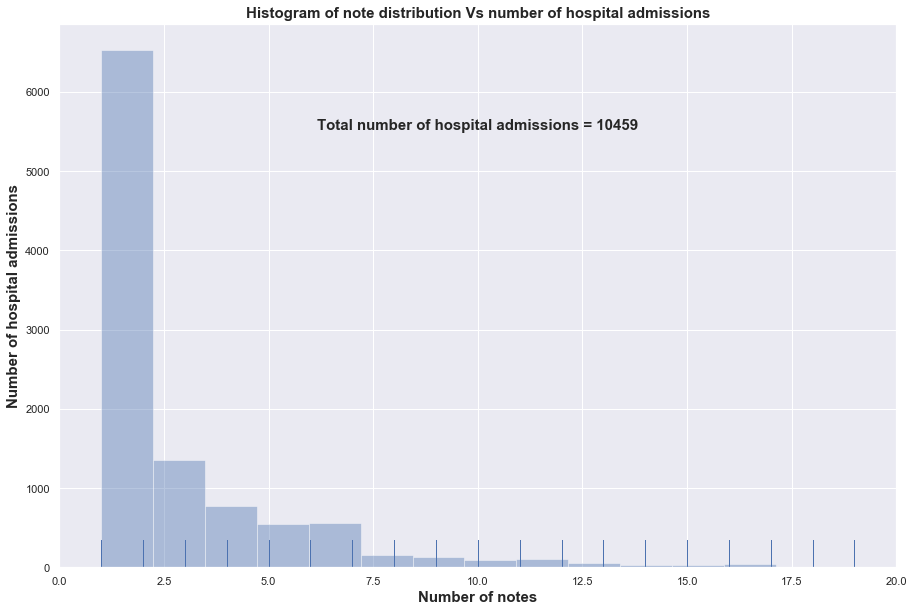

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['n_notes'], kde=False, ax=ax, rug=True, bins=50)
ax.set_xlabel('Number of notes', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_title('Histogram of note distribution Vs number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_xlim(0, 20)

ax.text(10, ax.get_ylim()[1]*0.80, f'Total number of hospital admissions = {len(df)}', fontweight='bold', fontsize=15, ha='center', va='bottom')

In [13]:
query = """
select hadm_id, avg(wait_period) as avg_wait_period from data where length(text) between 500 and 6000 group by hadm_id order by hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,hadm_id,avg_wait_period
0,100009,18.38
1,100012,47.07
2,100018,6.44
3,100020,21.22
4,100021,105.13


In [14]:
df['avg_wait_period'].min(), df['avg_wait_period'].mean(), df['avg_wait_period'].max()

(0.01, 87.56945979539154, 3269.1)

Text(300, 3512.8800000000006, 'Total number of hospital admissions = 10459')

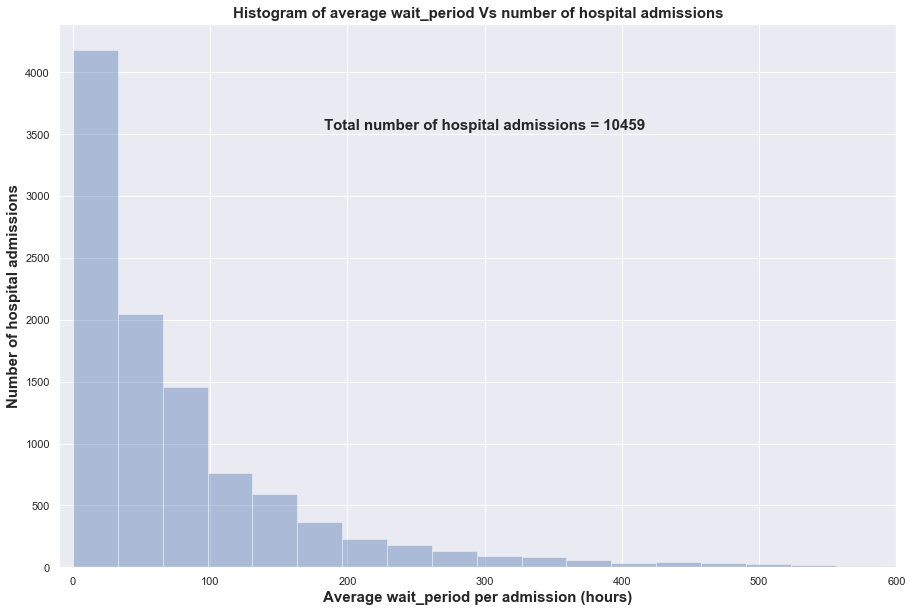

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['avg_wait_period'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Average wait_period per admission (hours)', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_title('Histogram of average wait_period Vs number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_xlim(-10, 600)

ax.text(300, ax.get_ylim()[1]*0.80, f'Total number of hospital admissions = {len(df)}', fontweight='bold', fontsize=15, ha='center', va='bottom')

In [16]:
query = """
with test as (select subject_id, count(distinct hadm_id) as n_adms from data where length(text) between 500 and 6000 group by subject_id order by subject_id) select n_adms, count(*) from test group by n_adms order by n_adms;
"""
df = pd.read_sql_query(query, con)
df.head()

,n_adms,count
0,1,9094
1,2,562
2,3,61
3,4,12
4,5,2


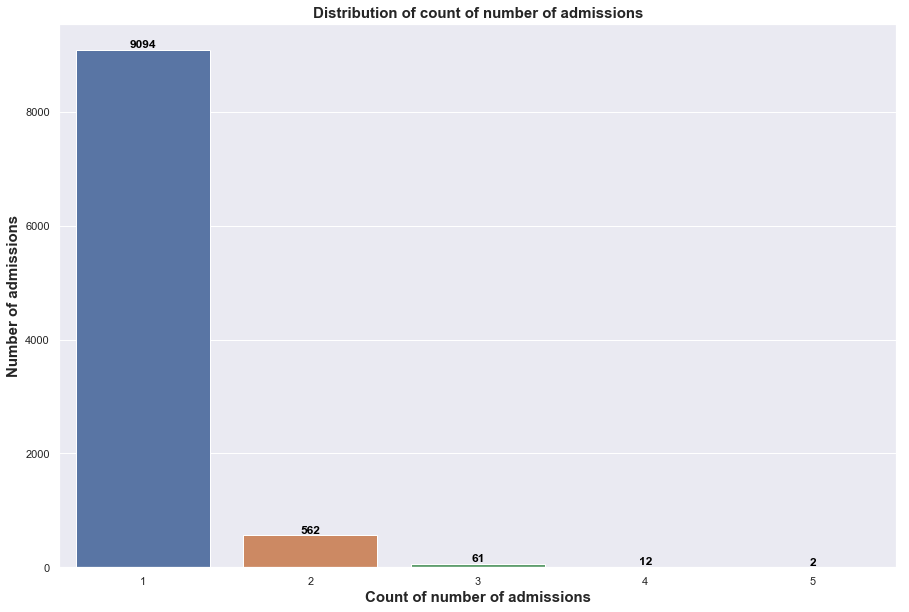

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='n_adms', y='count', data=df, ax=ax)
ax.set_xlabel("Count of number of admissions", fontweight='bold', fontsize=15)
ax.set_ylabel('Number of admissions', fontweight='bold', fontsize=15)
ax.set_title('Distribution of count of number of admissions', fontweight='bold', fontsize=15)
for index, row in df.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

In [18]:
query = """
with dtext as (select distinct text from data where length(text) between 500 and 6000) select length(text) as note_length from dtext;
"""
df = pd.read_sql_query(query, con)
df.head()

,note_length
0,797
1,1093
2,1232
3,1766
4,1082


In [19]:
df['note_length'].min(), df['note_length'].mean(), df['note_length'].max(), df['note_length'].std()

(500, 1715.6287643968808, 5998, 1052.2671999007625)

Text(3500, 1438.08, 'Total number of notes = 30649')

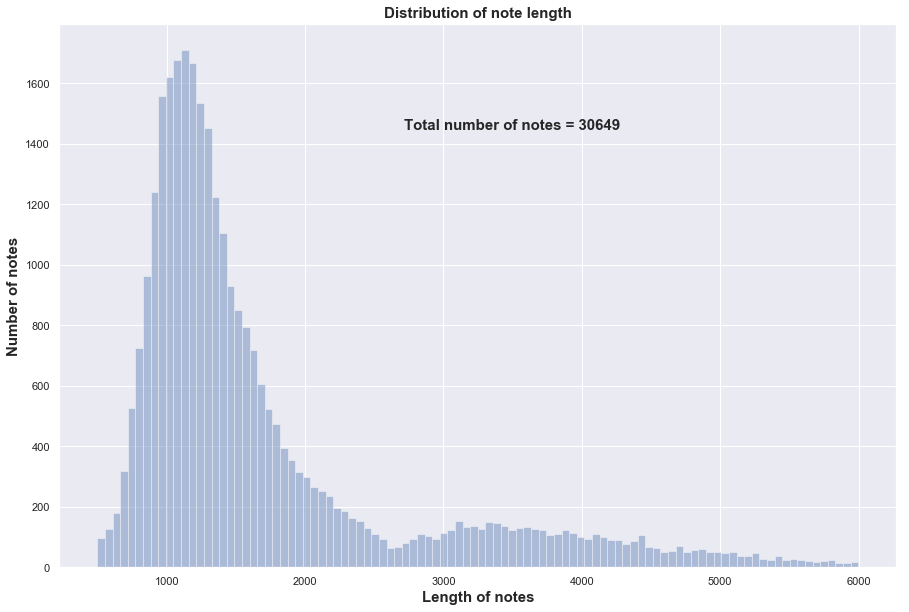

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['note_length'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Length of notes', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
ax.set_title('Distribution of note length', fontweight='bold', fontsize=15)
# ax.set_xlim(0, 9000)

ax.text(3500, ax.get_ylim()[1]*0.80, f"Total number of notes = {len(df)}", fontweight='bold', fontsize=15, ha='center', va='bottom')

In [21]:
con.close()